In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import shutil

# Set seed for reproducibility
np.random.seed(42)

# Initialize counter
total_images = 0

# Input data directory
input_dir = '/kaggle/input/brain-tumour-classification/BrainTumor_1/Train'

# Traverse and list all image files
for dirname, _, filenames in os.walk(input_dir):
    for filename in filenames:
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            total_images += 1

# ✅ Final summary
print(f"\n✅ Total images processed: {total_images}")


✅ Total images processed: 22848


In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import shutil

# Set seed for reproducibility
np.random.seed(42)

# 🔹 Define dataset directory
dataset_dir = "/kaggle/input/brain-tumour-classification/BrainTumor_1/Train"
output_base_dir = "/kaggle/working/processed_glioma"
os.makedirs(output_base_dir, exist_ok=True)

# 🔹 Target image size
image_size = (256, 256)

# 🔹 List of class folders to process
class_folders = ["glioma", "notumor", "meningioma", "pituitary"]

# 🔹 Counter for total processed images
total_processed = 0

def preprocess_image(image_path, output_path):
    try:
        img = cv2.imread(image_path)
        if img is None or img.size == 0:
            raise ValueError("Image could not be read or is empty.")
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Histogram equalization for contrast enhancement
        equalized = cv2.equalizeHist(gray)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(equalized, (5, 5), 0)

        # Resize to target shape
        resized = cv2.resize(blurred, image_size, interpolation=cv2.INTER_AREA)

        # Save the image
        Image.fromarray(resized).save(output_path)
        return True

    except Exception as e:
        print(f"⚠️ Error processing {image_path}: {e}")
        return False

# 🔹 Process all class folders
for class_name in class_folders:
    class_input_dir = os.path.join(dataset_dir, class_name)
    class_output_dir = os.path.join(output_base_dir, class_name)
    os.makedirs(class_output_dir, exist_ok=True)

    for img_file in os.listdir(class_input_dir):
        if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            input_path = os.path.join(class_input_dir, img_file)
            output_path = os.path.join(class_output_dir, img_file)
            if preprocess_image(input_path, output_path):
                total_processed += 1

# ✅ Final message
print(f"\n✅ All images processed and saved under: {output_base_dir}")
print(f"📸 Total number of images processed: {total_processed}")


✅ All images processed and saved under: /kaggle/working/processed_glioma
📸 Total number of images processed: 22848


In [3]:
# --- IMPORTS ---
import os
import cv2
import numpy as np
import shutil
import joblib
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# --- CONFIGURATION ---
processed_dir = "/kaggle/working/processed_glioma"
output_dir = "/kaggle/working/classified_brain_tumor_4class"
test_image_dir = "/kaggle/input/brain-tumour-classification/BrainTumor_1/Test/glioma"

model_path = "/kaggle/working/kmeans_4class.joblib"
pca_model_path = "/kaggle/working/normal_brain_pca.joblib"
normal_vector_path = "/kaggle/working/normal_brain_mean.npy"

image_size = (256, 256)
tumor_classes = ["glioma", "meningioma", "pituitary"]
no_tumor_class = "notumor"
hash_registry = set()

# --- SETUP OUTPUT FOLDER ---
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

# --- STEP 1: LEARN NORMAL BRAIN REPRESENTATION ---
def extract_feature_vector(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    resized = cv2.resize(img, image_size)
    normalized = resized.astype(np.float32) / 255.0
    return normalized.flatten()

normal_dir = os.path.join(processed_dir, no_tumor_class)
features_normal = []

for fname in os.listdir(normal_dir):
    fpath = os.path.join(normal_dir, fname)
    vec = extract_feature_vector(fpath)
    if vec is not None:
        features_normal.append(vec)

features_normal = np.array(features_normal)
pca = PCA(n_components=50, random_state=42)
pca.fit(features_normal)
mean_normal_vec = np.mean(pca.transform(features_normal), axis=0)

joblib.dump(pca, pca_model_path)
np.save(normal_vector_path, mean_normal_vec)

# --- COPY NO TUMOR IMAGES ---
no_tumor_out_dir = os.path.join(output_dir, "no_tumor")
os.makedirs(no_tumor_out_dir, exist_ok=True)

for fname in os.listdir(normal_dir):
    src = os.path.join(normal_dir, fname)
    dst = os.path.join(no_tumor_out_dir, fname)
    shutil.copy(src, dst)

# --- STEP 2: CLASSIFY TUMOR IMAGES ---
def compute_tumor_area(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return 0.0
    resized = cv2.resize(img, image_size)
    _, bin_img = cv2.threshold(resized, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    brain_mask = np.zeros_like(resized)
    if contours:
        brain_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(brain_mask, [brain_contour], -1, 255, -1)
    _, otsu = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    adaptive = cv2.adaptiveThreshold(resized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    combined = cv2.bitwise_or(otsu, adaptive)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
    tumor_mask = cv2.bitwise_and(closed, brain_mask)
    tumor_contours, _ = cv2.findContours(tumor_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    total_area = 0
    for c in tumor_contours:
        area = cv2.contourArea(c)
        if 20 < area < 50000:
            M = cv2.moments(c)
            if M["m00"] == 0:
                continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            if brain_mask[cy, cx] > 0:
                total_area += area
    return total_area

def classify_image(img_path):
    vec = extract_feature_vector(img_path)
    if vec is None:
        return "no_tumor", 0.0
    vec_pca = pca.transform([vec])[0]
    similarity = cosine_similarity([vec_pca], [mean_normal_vec])[0][0]
    if similarity >= 0.90:
        return "no_tumor", 0.0
    else:
        area = compute_tumor_area(img_path)
        return "tumor", area

areas = []
tumor_images = []

for folder in tumor_classes:
    class_dir = os.path.join(processed_dir, folder)
    for fname in os.listdir(class_dir):
        fpath = os.path.join(class_dir, fname)
        label, area = classify_image(fpath)
        image_hash = hashlib.md5(open(fpath, 'rb').read()).hexdigest()
        if image_hash in hash_registry:
            continue
        hash_registry.add(image_hash)
        if label == "tumor":
            areas.append([area])
            tumor_images.append((fpath, area))

# --- STEP 3: TRAIN KMEANS ---
if os.path.exists(model_path):
    kmeans = joblib.load(model_path)
else:
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=50)
    kmeans.fit(areas)
    joblib.dump(kmeans, model_path)

# --- STEP 4: MAP CLUSTERS TO SEVERITY ---
labels = kmeans.predict(areas)
cluster_means = [(i, np.mean([area[0] for j, area in enumerate(areas) if labels[j] == i])) for i in range(3)]
cluster_means.sort(key=lambda x: x[1])
cluster_to_label = {
    cluster_means[0][0]: "mild",
    cluster_means[1][0]: "moderate",
    cluster_means[2][0]: "severe"
}

# --- STEP 5: COPY CLASSIFIED TUMOR IMAGES ---
for (img_path, area), label in zip(tumor_images, labels):
    severity = cluster_to_label[label]
    out_dir = os.path.join(output_dir, severity)
    os.makedirs(out_dir, exist_ok=True)
    base_name = os.path.basename(img_path)
    shutil.copy(img_path, os.path.join(out_dir, base_name))

print("\n✅ Classification complete into 4 severity levels")
print(f"📂 Saved in: {output_dir}\n")


✅ Classification complete into 4 severity levels
📂 Saved in: /kaggle/working/classified_brain_tumor_4class



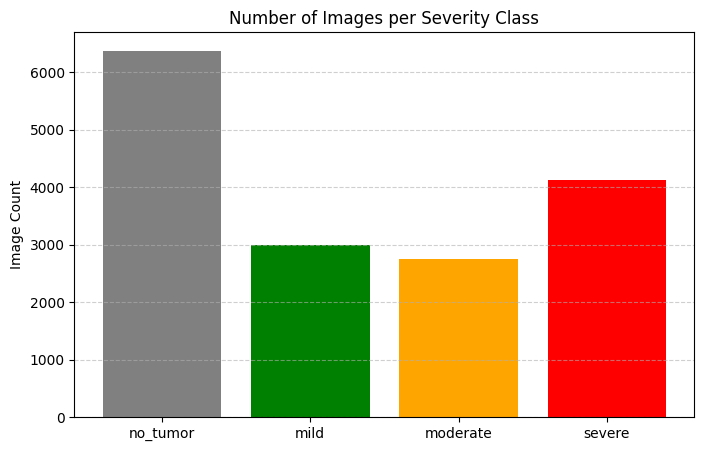

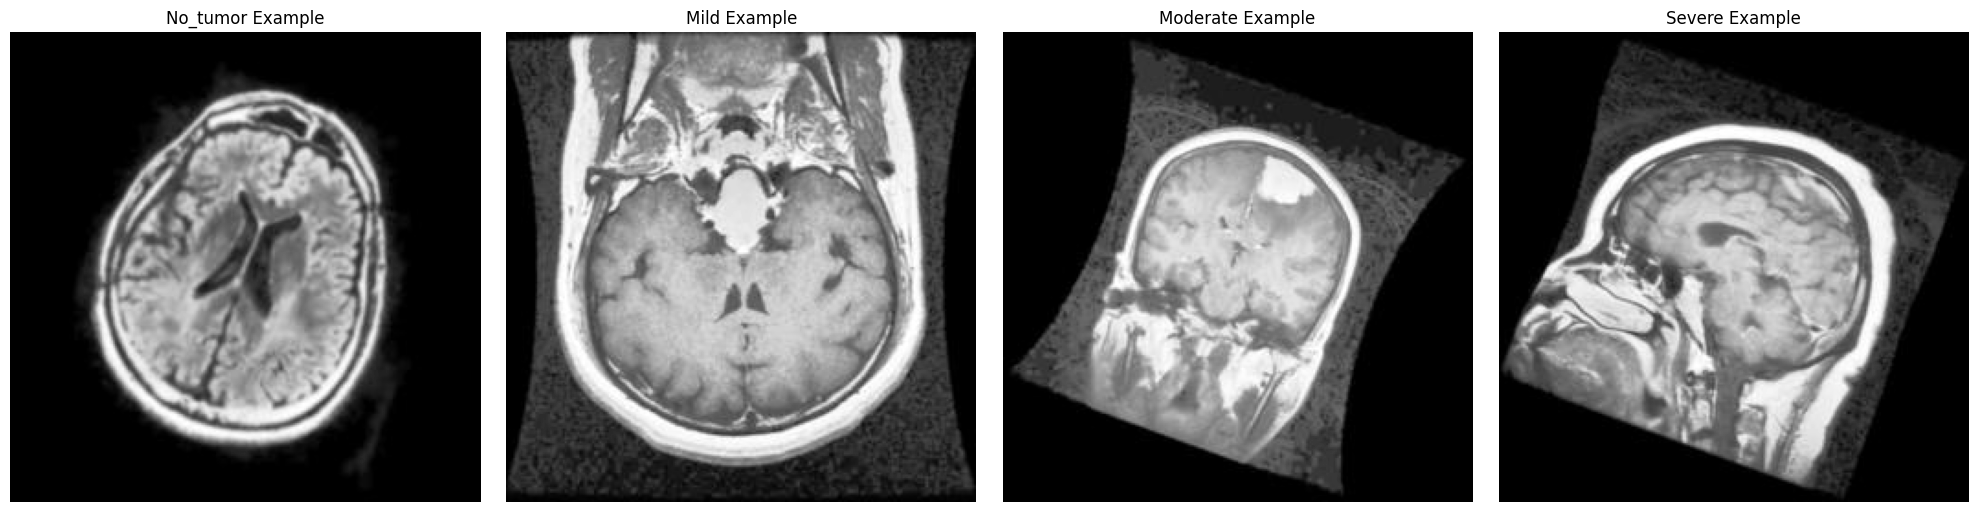

In [4]:
import os
import matplotlib.pyplot as plt
import cv2

classified_dir = "/kaggle/working/classified_brain_tumor_4class"
severity_classes = ["no_tumor", "mild", "moderate", "severe"]

# Count images in each class
class_counts = {cls: len(os.listdir(os.path.join(classified_dir, cls))) if os.path.exists(os.path.join(classified_dir, cls)) else 0
                for cls in severity_classes}

# Bar Plot for counts
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['gray', 'green', 'orange', 'red'])
plt.title("Number of Images per Severity Class")
plt.ylabel("Image Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Visualize 1 sample from each class (if available)
non_empty_classes = [cls for cls in severity_classes if class_counts[cls] > 0]

plt.figure(figsize=(5 * len(non_empty_classes), 5))
for idx, cls in enumerate(non_empty_classes):
    folder = os.path.join(classified_dir, cls)
    sample_img = next((f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))), None)
    if sample_img:
        img_path = os.path.join(folder, sample_img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, len(non_empty_classes), idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{cls.capitalize()} Example")
        plt.axis("off")

plt.tight_layout()
plt.show()

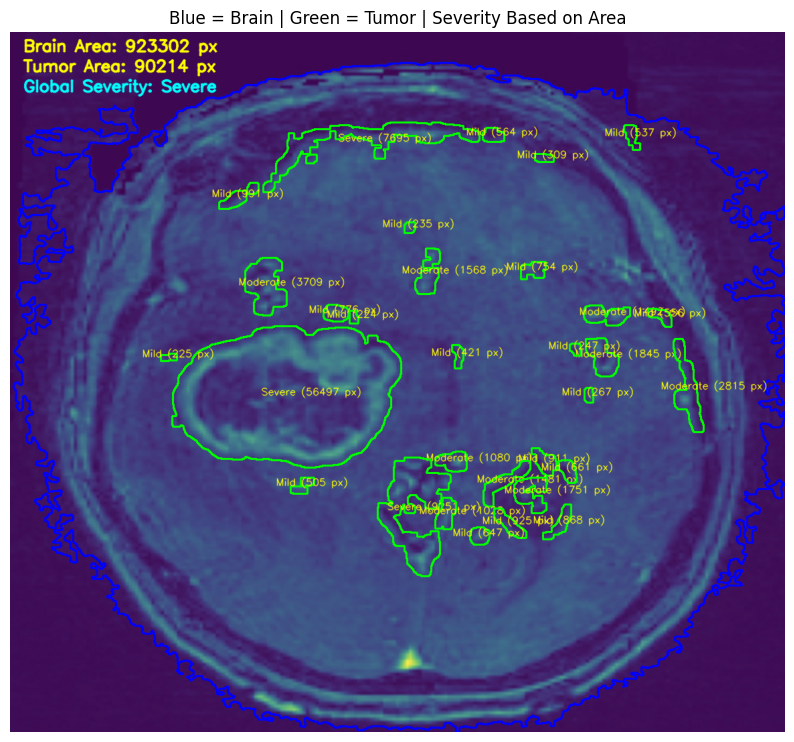

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter

# === Step 0: Load Image ===
image_path = "/kaggle/input/new-image/Image 4-30-25 at 19.09.jpg"
img = cv2.imread(image_path)
if img is None:
    raise ValueError("Image not loaded.")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
output = img.copy()
tumor_count = 0

# === Step 1: Brain Segmentation ===
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, brain_thresh = cv2.threshold(blurred, 40, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(brain_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
brain_contour = max(contours, key=cv2.contourArea)
cv2.drawContours(output, [brain_contour], -1, (255, 0, 0), 2)

# === Step 2: Brain Mask ===
brain_mask = np.zeros_like(gray)
cv2.drawContours(brain_mask, [brain_contour], -1, 255, thickness=cv2.FILLED)
masked_gray = cv2.bitwise_and(gray, gray, mask=brain_mask)

# === Step 3: Local Std Dev Map ===
def local_std(w): return np.std(w)
std_map = generic_filter(masked_gray.astype(np.float32), local_std, size=11)
std_map = cv2.normalize(std_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
threshold_std = np.percentile(std_map[brain_mask == 255], 75)
_, std_mask = cv2.threshold(std_map, threshold_std, 255, cv2.THRESH_BINARY)

# === Step 4: Bright + Edge Combination ===
_, bright_mask = cv2.threshold(masked_gray, 140, 255, cv2.THRESH_BINARY)
edges = cv2.Canny(masked_gray, 50, 150)
combined_mask = cv2.bitwise_or(std_mask, bright_mask)
combined_mask = cv2.bitwise_or(combined_mask, edges)
combined_dilated = cv2.dilate(combined_mask, np.ones((5, 5), np.uint8), iterations=2)

# === Step 5: Contour-Based Detection ===
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(combined_dilated, connectivity=8)
for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]
    if 200 < area < 60000 and cv2.pointPolygonTest(brain_contour, (float(cx), float(cy)), False) >= 0:
        tumor_mask = (labels == i).astype(np.uint8) * 255
        cnts, _ = cv2.findContours(tumor_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in cnts:
            cv2.drawContours(output, [cnt], -1, (0, 255, 0), 2)
            tumor_area = cv2.contourArea(cnt)
            if tumor_area < 1000:
                severity = "Mild"
            elif tumor_area < 5000:
                severity = "Moderate"
            else:
                severity = "Severe"

            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                cv2.putText(output, f"{severity} ({int(tumor_area)} px)", (cx - 40, cy),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
            tumor_count += 1

# === Step 6: Hough Circle Detection for Missed Rings ===
# === Step 6: Enhanced Hough Circle Logic ===
circles = cv2.HoughCircles(masked_gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=40,
                           param1=100, param2=45, minRadius=10, maxRadius=100)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for (x, y, r) in circles[0, :]:
        if r < 10 or r > 100:
            continue
        if cv2.pointPolygonTest(brain_contour, (float(x), float(y)), False) < 0:
            continue
        if x < 30 or x > gray.shape[1] - 30 or y < 30 or y > gray.shape[0] - 30:
            continue

        # Masks
        mask_ring = np.zeros_like(gray)
        mask_core = np.zeros_like(gray)
        cv2.circle(mask_ring, (x, y), r, 255, 2)
        cv2.circle(mask_core, (x, y), r - 6, 255, -1)

        ring_val = cv2.mean(masked_gray, mask=mask_ring)[0]
        core_val = cv2.mean(masked_gray, mask=mask_core)[0]
        contrast = ring_val - core_val

        print(f"Ring @ ({x},{y}) → ring={ring_val:.1f}, core={core_val:.1f}, contrast={contrast:.1f}")

        # ✅ Bonus Detection Rule: Strong bright ring, dark core
        if ring_val > 190 and core_val < 100 and contrast > 50:
            cv2.circle(output, (x, y), r, (255, 0, 255), 2)  # Magenta for strong tumor
            tumor_count += 1
        elif ring_val > 170 and core_val > 150 and 0 <= contrast <= 20:
            cv2.circle(output, (x, y), r, (0, 165, 255), 2)  # Orange
            tumor_count += 1
        elif 130 < ring_val < 240 and contrast > 15:
            cv2.circle(output, (x, y), r, (0, 255, 0), 2)  # Green
            tumor_count += 1


# === Step 7.1: Compute Total Tumor Area and Brain Area ===

# Total brain area (blue contour filled)
brain_filled_mask = np.zeros_like(gray)
cv2.drawContours(brain_filled_mask, [brain_contour], -1, 255, thickness=cv2.FILLED)
brain_area = np.sum(brain_filled_mask == 255)

# Total tumor area: only count those ≥ 1000 px
tumor_area_total = 0
for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]
    if 200 < area < 60000 and cv2.pointPolygonTest(brain_contour, (float(cx), float(cy)), False) >= 0:
        tumor_mask = (labels == i).astype(np.uint8) * 255
        cnts, _ = cv2.findContours(tumor_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in cnts:
            a = cv2.contourArea(cnt)
            if a >= 1000:
                tumor_area_total += a

# === Severity Classification ===
if tumor_area_total < 5000:
    global_severity = "Mild"
elif tumor_area_total < 20000:
    global_severity = "Moderate"
else:
    global_severity = "Severe"

# === Annotate final result ===
cv2.putText(output, f"Brain Area: {int(brain_area)} px", (20, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
cv2.putText(output, f"Tumor Area: {int(tumor_area_total)} px", (20, 60),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
cv2.putText(output, f"Global Severity: {global_severity}", (20, 90),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2, cv2.LINE_AA)

# === Final Display ===
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Blue = Brain | Green = Tumor | Severity Based on Area")
plt.show()

In [6]:
!pip install -q labelme

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 73.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 25.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 77.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 69.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.1 MB/s eta 0:00:00


In [7]:
import os
import shutil
from labelme import utils
from labelme.utils import shapes_to_label
import json
import numpy as np
from PIL import Image

# Set your input and output directories
input_dir = "/kaggle/input/rare-cancer"
output_image_dir = "/kaggle/working/images"
output_mask_dir = "/kaggle/working/masks"

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# Loop through all json files
for file in os.listdir(input_dir):
    if file.endswith(".json"):
        json_path = os.path.join(input_dir, file)
        base_name = file.replace(".json", "")
        img_file = base_name + ".png"
        img_path = os.path.join(input_dir, img_file)

        # Load labelme JSON
        with open(json_path) as f:
            data = json.load(f)

        # Decode image and label
        img = utils.img_b64_to_arr(data["imageData"])
        lbl, lbl_names = utils.labelme_shapes_to_label(img.shape, data["shapes"])

        # Convert label to binary mask (1 for tumor, 0 for background)
        binary_mask = (lbl > 0).astype(np.uint8) * 255

        # Save image & mask
        Image.fromarray(img).save(os.path.join(output_image_dir, img_file))
        Image.fromarray(binary_mask).save(os.path.join(output_mask_dir, base_name + "_mask.png"))

2025-05-01 18:25:05.648 | WARNING  | labelme.utils.shape:labelme_shapes_to_label:95 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
2025-05-01 18:25:05.672 | WARNING  | labelme.utils.shape:labelme_shapes_to_label:95 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
2025-05-01 18:25:05.696 | WARNING  | labelme.utils.shape:labelme_shapes_to_label:95 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
2025-05-01 18:25:05.722 | WARNING  | labelme.utils.shape:labelme_shapes_to_label:95 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
2025-05-01 18:25:05.745 | WARNING  | labelme.utils.shape:labelme_shapes_to_label:95 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
2025-05-01 18:25:05.768 | WARNING  | labelme.utils.shape:labelme_shapes_to_label:95 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
2025-05-01 18:25:05.792 | WARNING  | labelme.utils.shape:labelme

Image: /kaggle/working/images/UPENN-GBM-00002_11-13-2001-NA-BRAINROUTINE-13710_16.000000-t1 axial stealth-post  ProcessedCaPTk-96265.png
Mask: /kaggle/working/masks/UPENN-GBM-00002_11-13-2001-NA-BRAINROUTINE-13710_16.000000-t1 axial stealth-post  ProcessedCaPTk-96265_mask.png


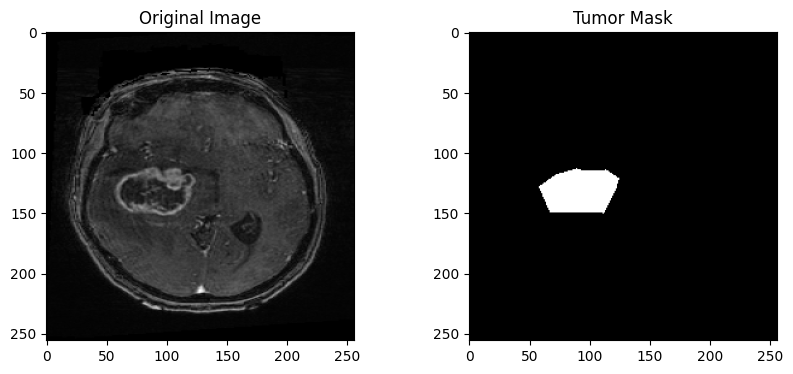

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Pick a random sample from images folder
image_files = sorted(os.listdir(output_image_dir))
mask_files = sorted(os.listdir(output_mask_dir))

# Preview the first one
sample_image_path = os.path.join(output_image_dir, image_files[0])
sample_mask_path = os.path.join(output_mask_dir, mask_files[0])

print("Image:", sample_image_path)
print("Mask:", sample_mask_path)

# Load and show
sample_image = Image.open(sample_image_path)
sample_mask = Image.open(sample_mask_path)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(sample_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Tumor Mask")
plt.imshow(sample_mask, cmap='gray')

plt.show()


In [9]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

In [10]:
# Set paths
image_dir = "/kaggle/working/images"
mask_dir = "/kaggle/working/masks"

# Parameters
IMG_SIZE = 256

def load_data(image_dir, mask_dir):
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    for img_name in image_files:
        img_path = os.path.join(image_dir, img_name)
        mask_name = img_name.replace(".png", "_mask.png")
        mask_path = os.path.join(mask_dir, mask_name)
        
        # Read image and mask
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None or mask is None:
            continue
        
        # Resize and normalize
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
        mask = np.expand_dims(mask, axis=-1)
        
        images.append(np.expand_dims(img, axis=-1))
        masks.append(mask)
        
    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

X, Y = load_data(image_dir, mask_dir)
print("Loaded:", X.shape, Y.shape)

# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

Loaded: (86, 256, 256, 1) (86, 256, 256, 1)


In [11]:
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    # Bottleneck
    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u1 = Conv2DTranspose(32, 2, strides=2, padding='same')(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = Conv2DTranspose(16, 2, strides=2, padding='same')(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

model = unet_model()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2)])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 128, 128, 32)   │          8,224 │ conv2d_5[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 64)   │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 32)   │         18,464 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 256, 256, 16)   │          2,064 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 32)   │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 256, 256, 16)   │          4,624 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 116,753 (456.07 KB)

 Trainable params: 116,753 (456.07 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=15,
    batch_size=8
)

Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7559 - loss: 0.6724 - mean_io_u: 0.4881 - val_accuracy: 0.9795 - val_loss: 0.4053 - val_mean_io_u: 0.4898
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9782 - loss: 0.3030 - mean_io_u: 0.4891 - val_accuracy: 0.9795 - val_loss: 0.1401 - val_mean_io_u: 0.4898
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9786 - loss: 0.1530 - mean_io_u: 0.4893 - val_accuracy: 0.9795 - val_loss: 0.1041 - val_mean_io_u: 0.4898
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9765 - loss: 0.1167 - mean_io_u: 0.4882 - val_accuracy: 0.9795 - val_loss: 0.0924 - val_mean_io_u: 0.4898
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9773 - loss: 0.0945 - mean_io_u: 0.4886 - val_accuracy: 0.9795 - val_loss: 0.0951 - val_mean_io_u: 0.4898
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9797 - loss: 0.0845 - mean_io_u: 0.4899 - val_accuracy: 0.9795 - val_loss: 0.0908 - val_mean_io_u:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


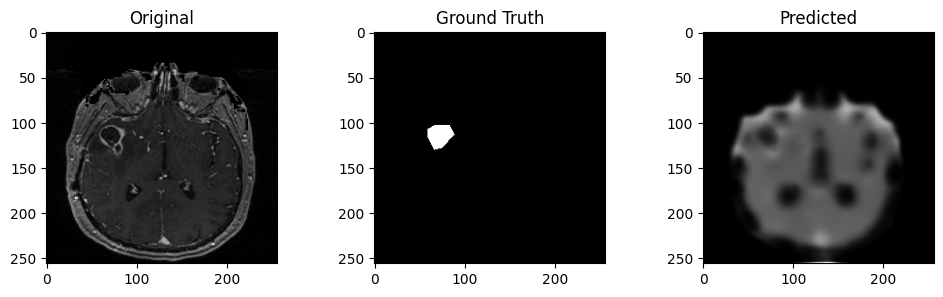

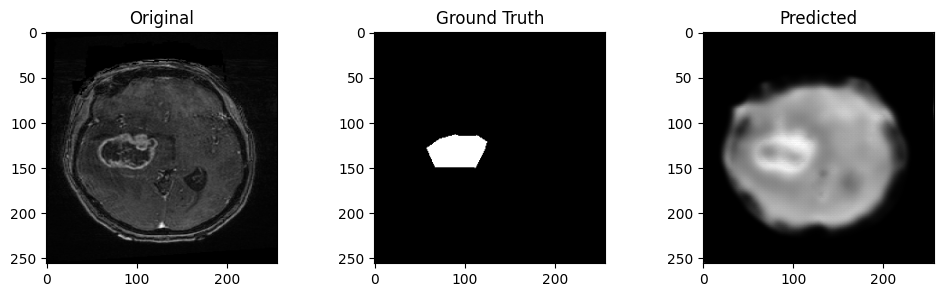

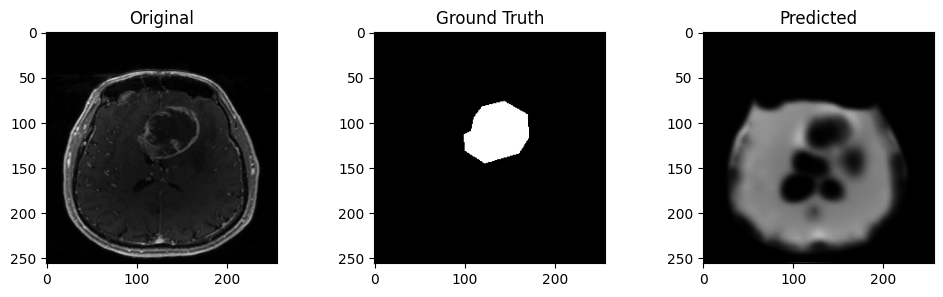

In [13]:
# Predict on validation
preds = model.predict(X_val)

# Show some results

for i in range(3):
    plt.figure(figsize=(12, 3))
    
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(Y_val[i].squeeze(), cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Predicted")
    plt.imshow(preds[i].squeeze(), cmap='gray')
    
    plt.show()

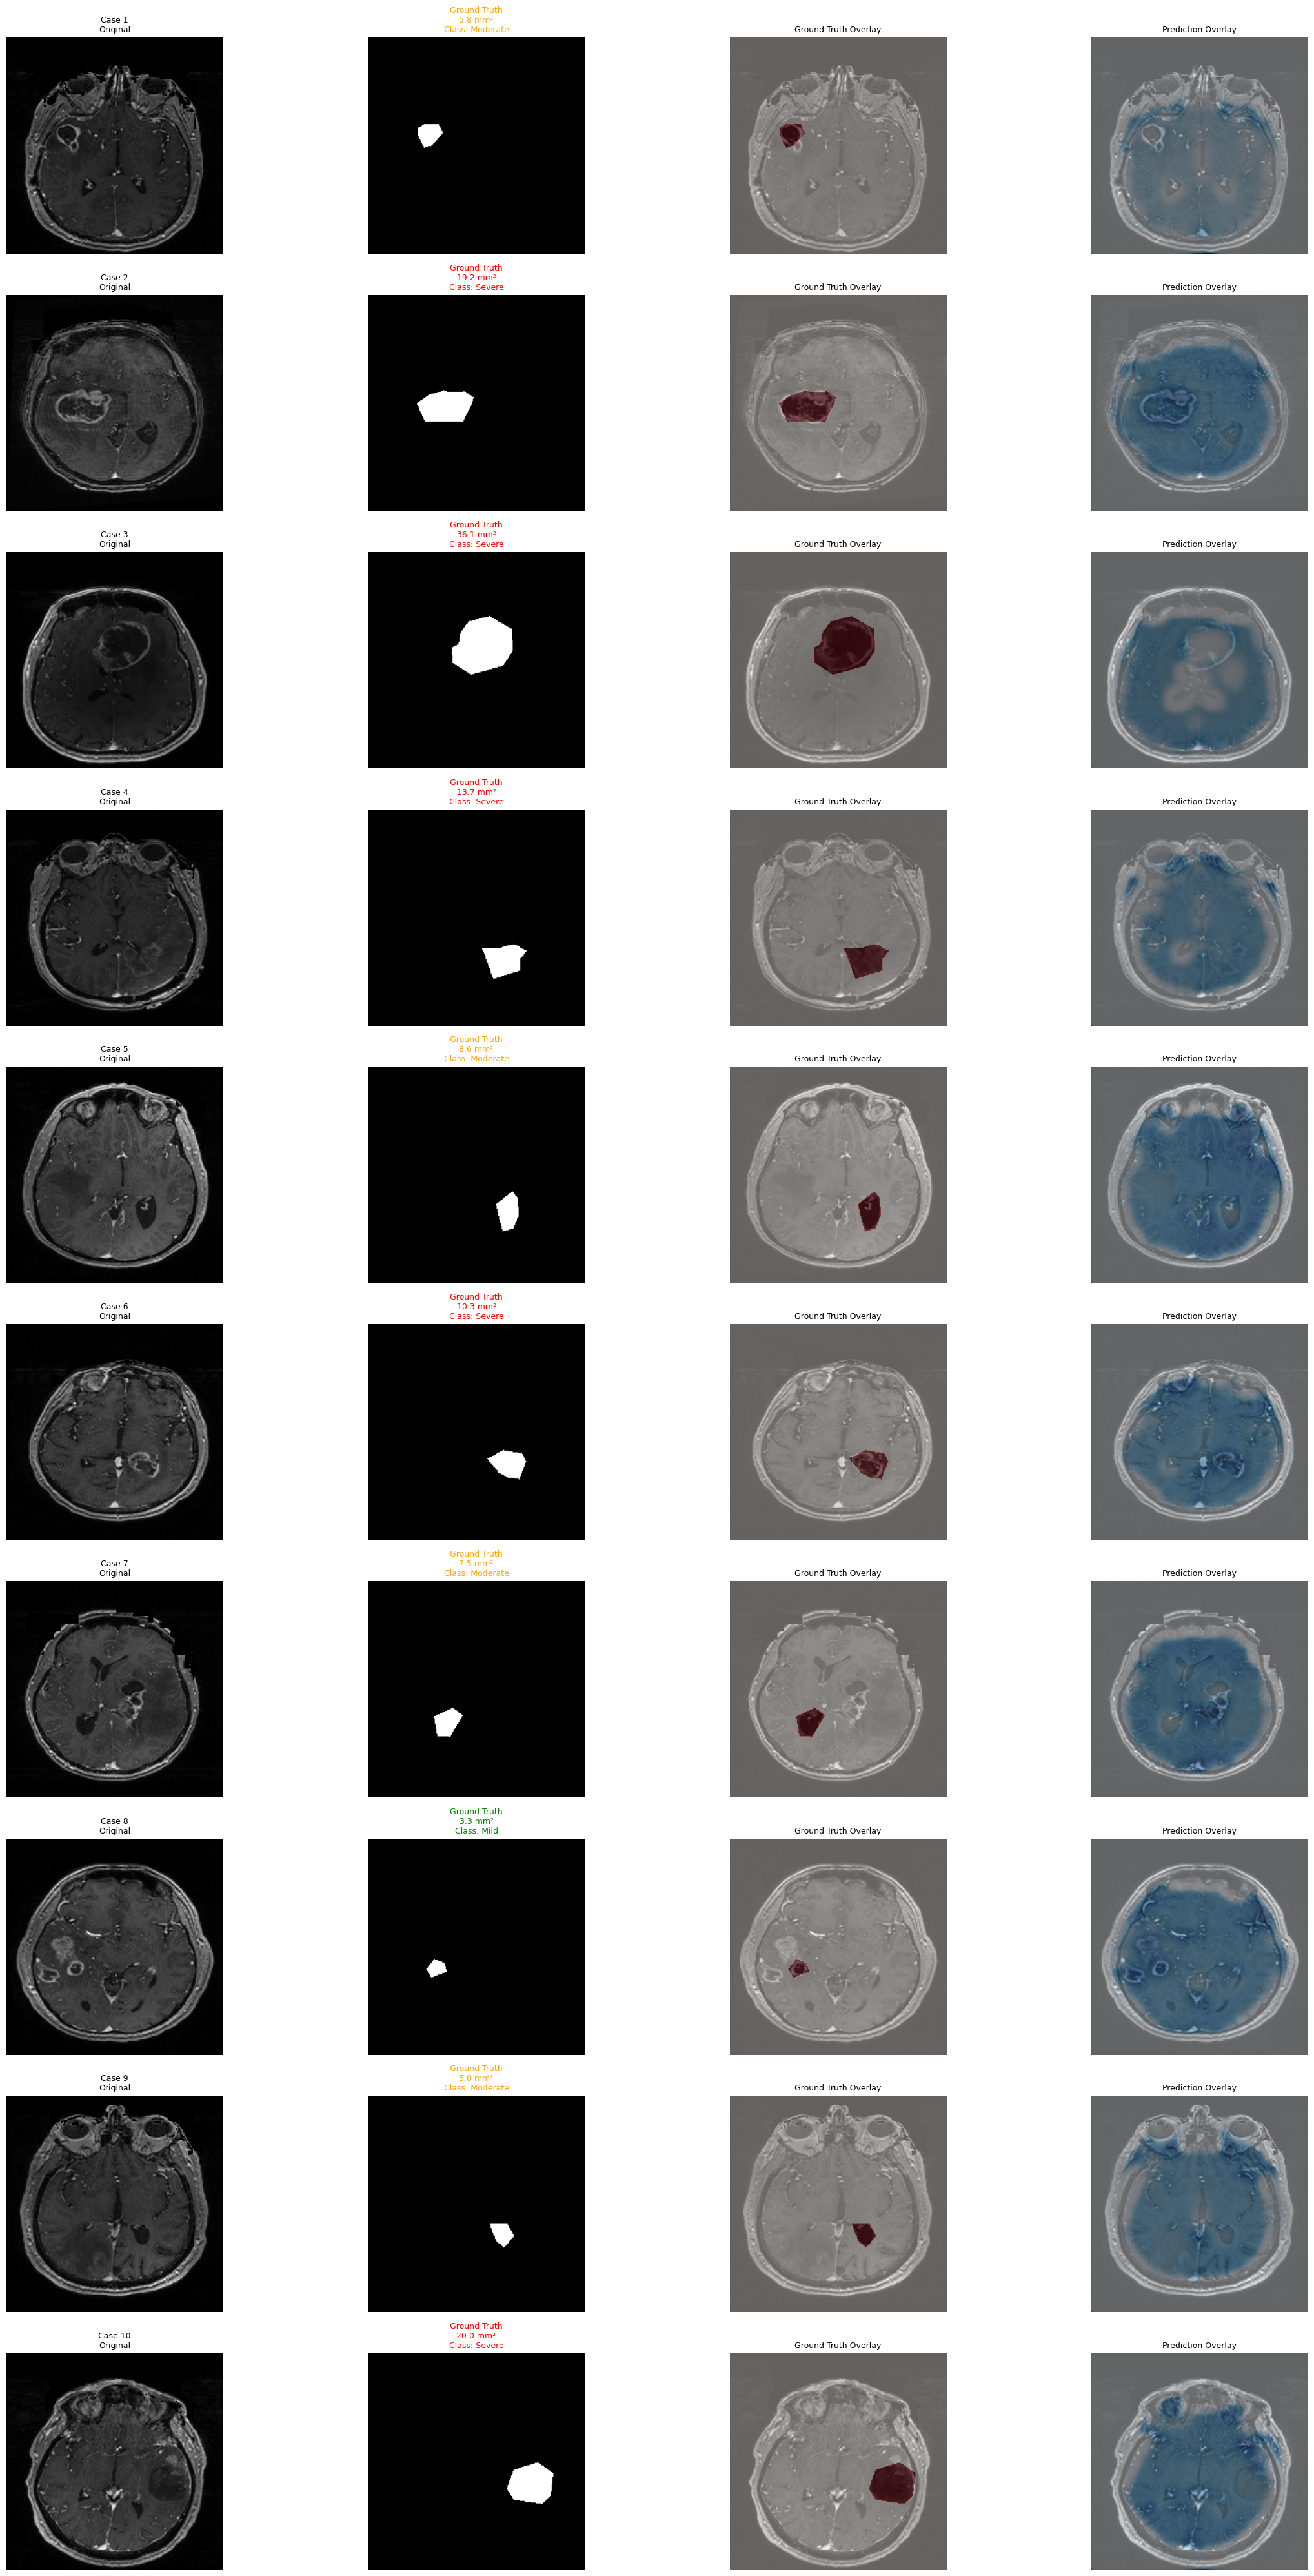


╔════════════════════════════════════════════════════════════╗
║               TUMOR CLASSIFICATION RESULTS              ║
╠══════╦════════════╦══════════════╦═════════════════════╣
║ Case ║ Area (mm²) ║ Class        ║ Visualization       ║
╠══════╬════════════╬══════════════╬═════════════════════╣
║  1  ║    5.8    ║ Moderate     ║ Moderate (5.8 mm²) ║
║  2  ║   19.2    ║ Severe       ║ Severe   (19.2 mm²) ║
║  3  ║   36.1    ║ Severe       ║ Severe   (36.1 mm²) ║
║  4  ║   13.7    ║ Severe       ║ Severe   (13.7 mm²) ║
║  5  ║    8.6    ║ Moderate     ║ Moderate (8.6 mm²) ║
║  6  ║   10.3    ║ Severe       ║ Severe   (10.3 mm²) ║
║  7  ║    7.5    ║ Moderate     ║ Moderate (7.5 mm²) ║
║  8  ║    3.3    ║ Mild         ║ Mild     (3.3 mm²) ║
║  9  ║    5.0    ║ Moderate     ║ Moderate (5.0 mm²) ║
║ 10  ║   20.0    ║ Severe       ║ Severe   (20.0 mm²) ║
╚══════╩════════════╩══════════════╩═════════════════════╝
* Thresholds: Mild (<5mm²) | Moderate (5-10mm²) | Severe (≥10mm²)


In [14]:
def calculate_and_classify_tumor(mask, pixel_size_mm=0.1):
    """Calculate tumor area and classify severity"""
    tumor_pixels = np.sum(mask > 0.5)
    tumor_area_mm2 = tumor_pixels * (pixel_size_mm ** 2)
    
    # Updated classification thresholds
    mild_threshold = 5    # mm²
    moderate_threshold = 10  # mm²
    
    if tumor_area_mm2 < mild_threshold:
        classification = "Mild"
    elif tumor_area_mm2 < moderate_threshold:
        classification = "Moderate"
    else:
        classification = "Severe"
    
    return tumor_pixels, tumor_area_mm2, classification

# Set up the visualization (4 columns x 10 rows)
plt.figure(figsize=(24, 40))  # Extra large figure for 10 examples

for i in range(10):
    # Calculate metrics
    gt_pixels, gt_area, gt_class = calculate_and_classify_tumor(Y_val[i].squeeze())
    
    # Original image
    plt.subplot(10, 4, i*4 + 1)
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    plt.title(f"Case {i+1}\nOriginal", fontsize=9)
    plt.axis('off')
    
    # Ground truth mask
    plt.subplot(10, 4, i*4 + 2)
    plt.imshow(Y_val[i].squeeze(), cmap='gray')
    plt.title(f"Ground Truth\n{gt_area:.1f} mm²\nClass: {gt_class}", 
              fontsize=9,
              color='green' if gt_class == 'Mild' else 
                   'orange' if gt_class == 'Moderate' else 'red')
    plt.axis('off')
    
    # Ground truth overlay
    plt.subplot(10, 4, i*4 + 3)
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    plt.imshow(Y_val[i].squeeze(), alpha=0.4, cmap='Reds')
    plt.title("Ground Truth Overlay", fontsize=9)
    plt.axis('off')
    
    # Prediction overlay
    plt.subplot(10, 4, i*4 + 4)
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    plt.imshow(preds[i].squeeze(), alpha=0.4, cmap='Blues')
    plt.title("Prediction Overlay", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Detailed color-coded table
print("\n╔════════════════════════════════════════════════════════════╗")
print("║               TUMOR CLASSIFICATION RESULTS              ║")
print("╠══════╦════════════╦══════════════╦═════════════════════╣")
print("║ Case ║ Area (mm²) ║ Class        ║ Visualization       ║")
print("╠══════╬════════════╬══════════════╬═════════════════════╣")

for i in range(10):
    _, gt_area, gt_class = calculate_and_classify_tumor(Y_val[i].squeeze())
    
    # Color coding
    if gt_class == "Mild":
        color = '\033[92m'  # Green 
    elif gt_class == "Moderate":
        color = '\033[93m'  # Yellow
    else:
        color = '\033[91m'  # Red

    
    print(f"║ {i+1:2d}  ║ {gt_area:6.1f}    ║ {color}{gt_class:12s}\033[0m ║ {gt_class:8s} ({gt_area:.1f} mm²) ║")

print("╚══════╩════════════╩══════════════╩═════════════════════╝")
print("* Thresholds: Mild (<5mm²) | Moderate (5-10mm²) | Severe (≥10mm²)")